# Importing Necessary Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm

# Functions of y1 and y2 for checking y_loss

In [2]:
def f_y_1(x0, x1):
    return torch.cos(49 * x0 + 42 * x1)

def f_y_2(x0, x1):
    return torch.cos(56 * x0 + 63 * x1)

# Hyperparameters

In [3]:
number_of_points = 50
in_channels1 = 1
out_channels1 = 16
kernel_size1 = (16, 2) 
out_channels2 = 32
kernel_size2 = (8, 2)
out_channels3 = 64
kernel_size3 = (4, 2)
kernel_size4 = (16,2)
padding = (0, 1)
dimInt = (number_of_points-kernel_size1[0]+1-kernel_size2[0]+1-kernel_size3[0]+1)
latent_dim = 800
hidden_dim = 100
batch_size = 32

# Model Architecture

In [4]:
class Encoder(nn.Module):
    def __init__(self, in_channels1, out_channels1, kernel_size1, out_channels2, kernel_size2, out_channels3, kernel_size3, dimInt, latent_dim):
        super(Encoder, self).__init__()
        
        self.C1 = nn.Conv2d(in_channels1, out_channels1, kernel_size=kernel_size1)
        self.relu = nn.ReLU()

        self.C2 = nn.Conv2d(out_channels1, out_channels2, kernel_size=kernel_size2)
        self.tanh = nn.Tanh()

        self.C3 = nn.Conv2d(out_channels2, out_channels3, kernel_size=kernel_size3)
        
        self.mu = nn.Linear(out_channels3 * dimInt, latent_dim)
        
        self.log_var = nn.Linear(out_channels3 * dimInt, latent_dim)
        
    def forward(self, x, cond):

        # print(x.shape, cond.shape)
        x_ = torch.cat([x, cond], dim=3)
        # print(x_.shape)

        x_ = self.relu(self.C1(x_))
        # print(x_.shape)

        x_ = self.tanh(self.C2(x_))
        # print(x_.shape)

        x_ = self.relu(self.C3(x_))
        # print(x_.shape)

        x_ = x_.view(x_.shape[0], -1)
        # print(x_.shape)
        
        z_mu = self.mu(x_)
        # print(z_mu.shape)
        
        z_log_var = self.log_var(x_)
        # print(z_log_var.shape)

        return z_mu, z_log_var

In [5]:
class Sampling(nn.Module):
    def __init__(self):
        super(Sampling, self).__init__()

    def forward(self, z_mu, z_log_var):
        
        std = torch.exp(0.5 * z_log_var)
        eps = torch.randn_like(std)
        
        
        # print((z_mu + eps * std).shape)
        
        return z_mu + eps * std

In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, number_of_points, out_channels3, dimInt, out_channels2, kernel_size3, out_channels1, kernel_size2, in_channels1, kernel_size4, padding):
        super(Decoder, self).__init__()

        self.L1 = nn.Linear(latent_dim, hidden_dim)
        self.relu = nn.ReLU()

        self.L2 = nn.Linear(2*hidden_dim, out_channels3 * dimInt)
        self.tanh = nn.Tanh()

        self.CT1 = nn.ConvTranspose2d(out_channels3, out_channels2, kernel_size=kernel_size3)

        self.CT2 = nn.ConvTranspose2d(out_channels2, out_channels1, kernel_size=kernel_size2)

        self.CT3 = nn.ConvTranspose2d(out_channels1, in_channels1, kernel_size=kernel_size4,  padding=padding)


        
        self.number_of_points = number_of_points
    def forward(self, x, cond):
        
        # print(x.shape)
        # print(cond.shape)
        x = self.relu(self.L1(x))
        # print(x.shape)
        
        cond = torch.reshape(cond, (len(cond), self.number_of_points * 2))
        # print(cond.shape)
        x = torch.cat([x, cond], dim=1)
        # print(x.shape)

        x = self.tanh(self.L2(x))
        # print(x.shape)
        
        x = x.view(x.shape[0], out_channels3, -1, 1)
        # print(x.shape)

        x = self.relu(self.CT1(x))
        # print(x.shape)

        x = self.relu(self.CT2(x))
        # print(x.shape)
        
        x = self.relu(self.CT3(x))
        # print(x.shape)

        return x

In [7]:
class CVAE(nn.Module):
    def __init__(self, in_channels1, out_channels1, kernel_size1, out_channels2, kernel_size2, out_channels3, kernel_size3, dimInt, latent_dim, hidden_dim, number_of_points, kernel_size4, padding):
        super(CVAE, self).__init__()
        self.encoder = Encoder(in_channels1, out_channels1, kernel_size1, out_channels2, kernel_size2, out_channels3, kernel_size3, dimInt, latent_dim)
        self.sampling = Sampling()
        self.decoder = Decoder(latent_dim, hidden_dim, number_of_points, out_channels3, dimInt, out_channels2, kernel_size3, out_channels1, kernel_size2, in_channels1, kernel_size4, padding)

    def forward(self, x, cond):
        z_mu, z_log_var = self.encoder(x, cond)

        z = self.sampling(z_mu, z_log_var)

        x_hat = self.decoder(z, cond)

        return z_mu, z_log_var, x_hat
        

In [8]:
Model = CVAE(in_channels1, out_channels1, kernel_size1, out_channels2, kernel_size2, out_channels3, kernel_size3, dimInt, latent_dim, hidden_dim, number_of_points, kernel_size4, padding)

# Loading the dataset into train Loader

In [9]:
train_dataset = torch.load('/kaggle/input/bh-data-original/train_dataset.pt')
X0_X1, Y1_Y2 = train_dataset.tensors
X0_X1.shape, Y1_Y2.shape

(torch.Size([100000, 1, 50, 2]), torch.Size([100000, 1, 50, 2]))

In [10]:
Train_Dataset = TensorDataset(X0_X1, Y1_Y2)
train_loader = DataLoader(Train_Dataset, batch_size=batch_size, shuffle=True)

# Defining loss function

In [11]:
def loss_function(x0_x1, x_hat, z_mu, z_log_var, y1_y2):
    
    recon_loss_fn = torch.nn.L1Loss(reduction='mean')
    
    x_loss = recon_loss_fn(x0_x1, x_hat)
    x_loss = x_loss * 2
    
    KLD = -0.5 * torch.sum(1 + z_log_var - z_mu.pow(2) - z_log_var.exp())

    x0 = x_hat[:,:,:,0]
    x1 = x_hat[:,:,:,1]
    y1 = f_y_1(x0, x1)
    y2 = f_y_2(x0, x1)
    y1 = y1.view(-1, 1, 50, 1)
    y2 = y2.view(-1, 1, 50, 1)
    y_hat = torch.cat([y1, y2], dim=3)
    y_loss = recon_loss_fn(y1_y2, y_hat)
    y_loss = y_loss * 1.3
    
    
    return x_loss, KLD, y_loss, x_loss + KLD + y_loss

# Function to generate samples

In [12]:
def generate_samples(num_samples, given_y):
    samples = torch.tensor([])
    samples = samples.to(device)
    givens = torch.tensor([])
    givens = givens.to(device)
    given_y = given_y.to(device)
    Model.eval()
    with torch.no_grad():
        for i, _ in enumerate(range(num_samples)):
            z_rand = torch.randn(1, 50, 2)
            z_rand = z_rand.to(device)
            z_mu, z_log_var = Model.encoder(torch.unsqueeze(z_rand, dim=0), given_y[i,:,:,:].unsqueeze(0))
            z = Model.sampling(z_mu, z_log_var)
            
            sample = Model.decoder(z, given_y[i,:,:,:])
            samples = torch.cat([samples, sample], dim=0)   
            
    givens = torch.cat([givens, given_y], dim=0) 

    return samples, givens

# GPU setup

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [14]:
Model.to(device)

CVAE(
  (encoder): Encoder(
    (C1): Conv2d(1, 16, kernel_size=(16, 2), stride=(1, 1))
    (relu): ReLU()
    (C2): Conv2d(16, 32, kernel_size=(8, 2), stride=(1, 1))
    (tanh): Tanh()
    (C3): Conv2d(32, 64, kernel_size=(4, 2), stride=(1, 1))
    (mu): Linear(in_features=1600, out_features=800, bias=True)
    (log_var): Linear(in_features=1600, out_features=800, bias=True)
  )
  (sampling): Sampling()
  (decoder): Decoder(
    (L1): Linear(in_features=800, out_features=100, bias=True)
    (relu): ReLU()
    (L2): Linear(in_features=200, out_features=1600, bias=True)
    (tanh): Tanh()
    (CT1): ConvTranspose2d(64, 32, kernel_size=(4, 2), stride=(1, 1))
    (CT2): ConvTranspose2d(32, 16, kernel_size=(8, 2), stride=(1, 1))
    (CT3): ConvTranspose2d(16, 1, kernel_size=(16, 2), stride=(1, 1), padding=(0, 1))
  )
)

# Function to plot samples

In [16]:
def plot_samples(num_samples, x0_x1, y1_y2):
    x0_x1 = x0_x1.to("cpu")
    y1_y2 = y1_y2.to("cpu")
    for i in range(num_samples):
        
        x0 = x0_x1[i,0,:,0]
        x1 = x0_x1[i,0,:,1]
        y1 = y1_y2[i,0,:,0]
        y2 = y1_y2[i,0,:,1]
        y1_hat = f_y_1(x0, x1)
        y2_hat = f_y_2(x0, x1)
        plt.plot(x0.detach().numpy(), label="X0")
        plt.plot(x1.detach().numpy(), label="X1")
        plt.plot(y1.detach().numpy(), label="Y1")
        plt.plot(y2.detach().numpy(), label="Y2")
        plt.plot(y1_hat.detach().numpy(), label="Y1_hat")
        plt.plot(y2_hat.detach().numpy(), label="Y2_hat")
        plt.legend()
        plt.show()

# Plotting some examples

In [17]:
for batch in train_loader:
    x1_x2, y1_y2 = batch 
    break

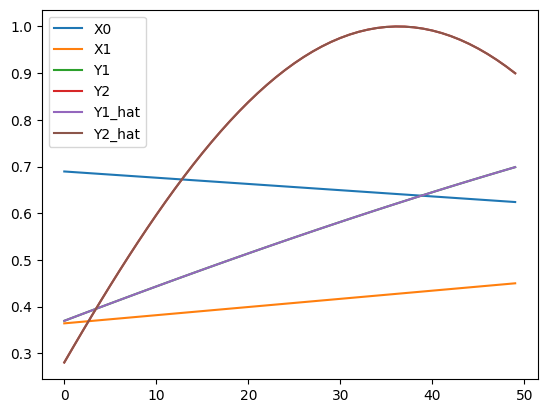

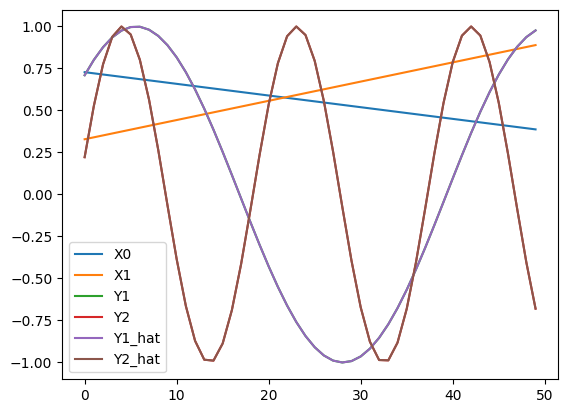

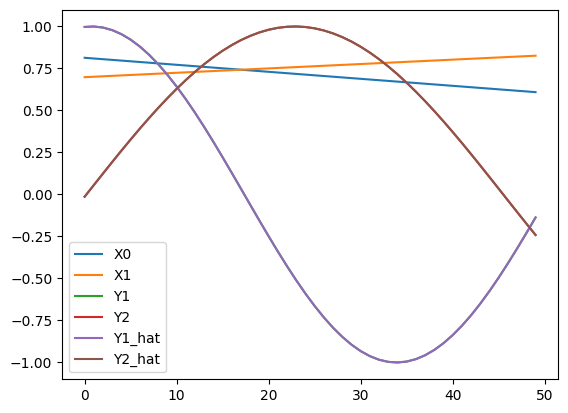

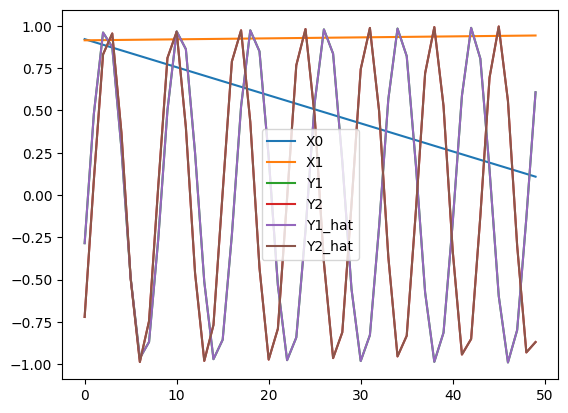

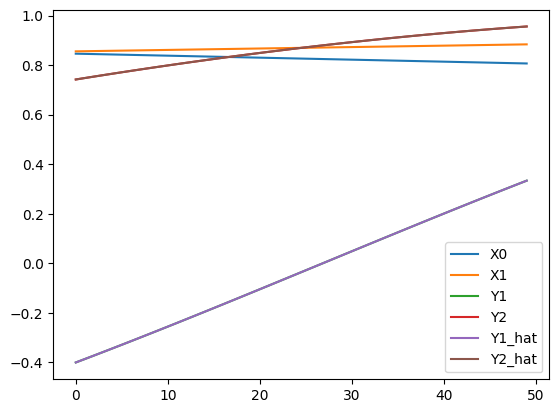

In [18]:
num_samples=5
plot_samples(num_samples, x1_x2, y1_y2)

In [19]:
num_samples = 5
for batch in train_loader:
    x1_x2, y1_y2 = batch 
    y_givens = y1_y2[:5,:,:,:]
    break

**Plot samples generated from untrained model**

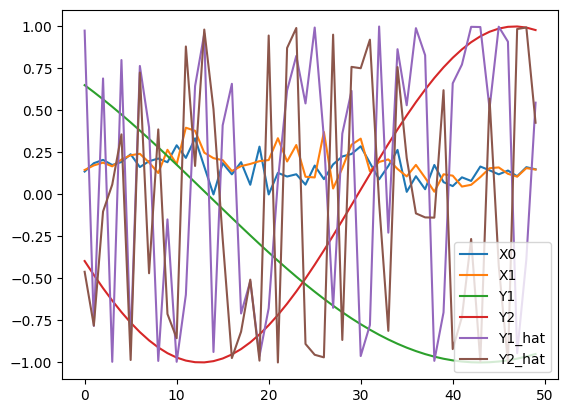

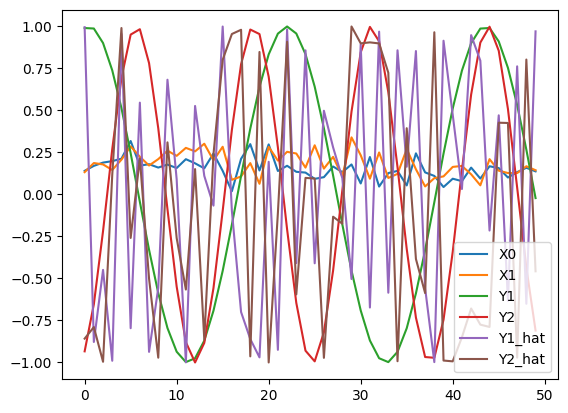

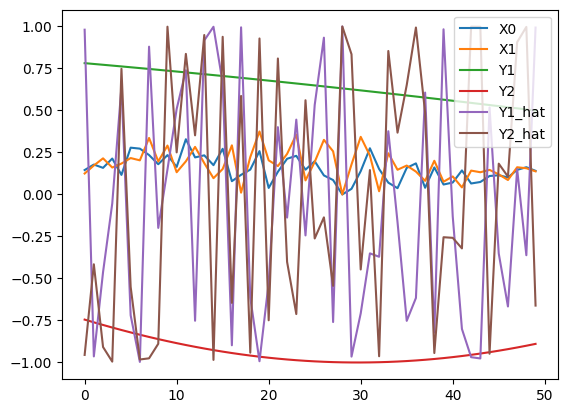

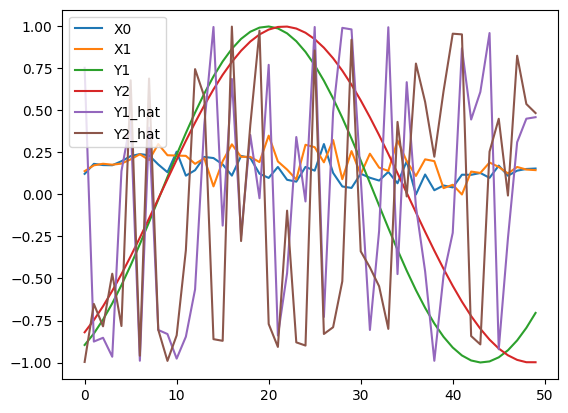

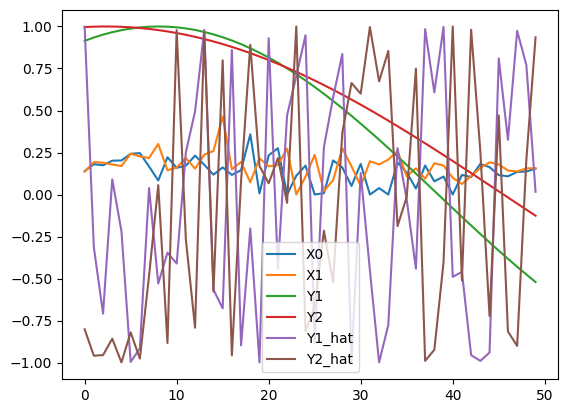

In [20]:
samples, givens = generate_samples(num_samples, y_givens)
plot_samples(num_samples, samples, givens)

# Setting up optimizer and learning rate scheduler

In [21]:
optimizer = torch.optim.Adam(Model.parameters(), lr=0.001)

In [22]:
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)

# Model Training

In [23]:
loss_ = []

epochs = 20

for epoch in range(epochs):
    running_x_loss = 0
    running_y_loss = 0
    running_KLD = 0
    running_loss = 0
    
    for batch in tqdm(train_loader):
        x0_x1, y1_y2 = batch
        x0_x1 = x0_x1.to(device)
        y1_y2 = y1_y2.to(device)
        
        Model.train()  
        z_mu, z_log_var, x_hat = Model(x0_x1, y1_y2)
        
        
        x_loss, KLD, y_loss, loss = loss_function(x0_x1, x_hat, z_mu, z_log_var, y1_y2)
        x_loss, KLD, y_loss, loss = x_loss.to(device), KLD.to(device), y_loss.to(device), loss.to(device)
        
        running_loss += loss.item()
        running_y_loss += y_loss.item()
        running_x_loss += x_loss.item()
        running_KLD += KLD.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    running_KLD = running_KLD / len(train_loader)
    running_loss = running_loss / len(train_loader)
    running_y_loss = running_y_loss / len(train_loader)
    running_x_loss = running_x_loss / len(train_loader)
    scheduler.step()
    
    loss_.append(running_loss)
    
    print(f'{epoch + 1}/{epochs} Loss: {running_loss} KLD: {running_KLD} y_loss: {running_y_loss} x_loss: {running_x_loss}')


  0%|          | 0/3125 [00:00<?, ?it/s]

1/20 Loss: 1.4605121252059936 KLD: 0.02607649857521057 y_loss: 0.9495947823524475 x_loss: 0.48484084542274475


  0%|          | 0/3125 [00:00<?, ?it/s]

2/20 Loss: 0.8825167066192627 KLD: 0.0001130205249786377 y_loss: 0.4334597443580627 x_loss: 0.44894394136428833


  0%|          | 0/3125 [00:00<?, ?it/s]

3/20 Loss: 0.7990217517852783 KLD: 0.00013479022026062013 y_loss: 0.3482141576004028 x_loss: 0.4506728043842316


  0%|          | 0/3125 [00:00<?, ?it/s]

4/20 Loss: 0.7690591350746154 KLD: 0.00014435334205627442 y_loss: 0.3178531509876251 x_loss: 0.4510616303539276


  0%|          | 0/3125 [00:00<?, ?it/s]

5/20 Loss: 0.7507172417640686 KLD: 0.00014549970626831054 y_loss: 0.2993063617515564 x_loss: 0.4512653805446625


  0%|          | 0/3125 [00:00<?, ?it/s]

6/20 Loss: 0.7399362514686585 KLD: 0.00014634033203125 y_loss: 0.2883368129968643 x_loss: 0.4514530982208252


  0%|          | 0/3125 [00:00<?, ?it/s]

7/20 Loss: 0.7305359269905091 KLD: 0.000145802001953125 y_loss: 0.278817071595192 x_loss: 0.4515730535888672


  0%|          | 0/3125 [00:00<?, ?it/s]

8/20 Loss: 0.7243541837120057 KLD: 0.000146583251953125 y_loss: 0.2724918797445297 x_loss: 0.4517157206249237


  0%|          | 0/3125 [00:00<?, ?it/s]

9/20 Loss: 0.7171582976150512 KLD: 0.0001463653564453125 y_loss: 0.2651689951086044 x_loss: 0.4518429371070862


  0%|          | 0/3125 [00:00<?, ?it/s]

10/20 Loss: 0.7113295972633362 KLD: 0.00014623870849609375 y_loss: 0.25928389523029327 x_loss: 0.45189946412086485


  0%|          | 0/3125 [00:00<?, ?it/s]

11/20 Loss: 0.6994756867980957 KLD: 0.00014241851806640624 y_loss: 0.24726998391151428 x_loss: 0.45206328446388244


  0%|          | 0/3125 [00:00<?, ?it/s]

12/20 Loss: 0.6940983151626587 KLD: 0.000142259521484375 y_loss: 0.24162018179416656 x_loss: 0.45233587381362916


  0%|          | 0/3125 [00:00<?, ?it/s]

13/20 Loss: 0.6896204516410828 KLD: 0.00014239593505859375 y_loss: 0.23682275007247924 x_loss: 0.4526553053379059


  0%|          | 0/3125 [00:00<?, ?it/s]

14/20 Loss: 0.6845883663749694 KLD: 0.00013967559814453124 y_loss: 0.23149859785079957 x_loss: 0.45295009279251097


  0%|          | 0/3125 [00:00<?, ?it/s]

15/20 Loss: 0.6799945174407959 KLD: 0.000140601806640625 y_loss: 0.22657448965072632 x_loss: 0.453279425907135


  0%|          | 0/3125 [00:00<?, ?it/s]

16/20 Loss: 0.6762699878501892 KLD: 0.00014041046142578126 y_loss: 0.22261768841266633 x_loss: 0.45351188930511477


  0%|          | 0/3125 [00:00<?, ?it/s]

17/20 Loss: 0.6730863665199279 KLD: 0.000140457763671875 y_loss: 0.2192744100189209 x_loss: 0.4536714986228943


  0%|          | 0/3125 [00:00<?, ?it/s]

18/20 Loss: 0.66982625831604 KLD: 0.00013974639892578124 y_loss: 0.21583434071063995 x_loss: 0.45385217117309573


  0%|          | 0/3125 [00:00<?, ?it/s]

19/20 Loss: 0.6666754848480224 KLD: 0.00014018829345703124 y_loss: 0.21252521045684813 x_loss: 0.45401008615493776


  0%|          | 0/3125 [00:00<?, ?it/s]

20/20 Loss: 0.664651628780365 KLD: 0.000140450439453125 y_loss: 0.21033499095439911 x_loss: 0.4541761872959137


# Plotting some samples after training

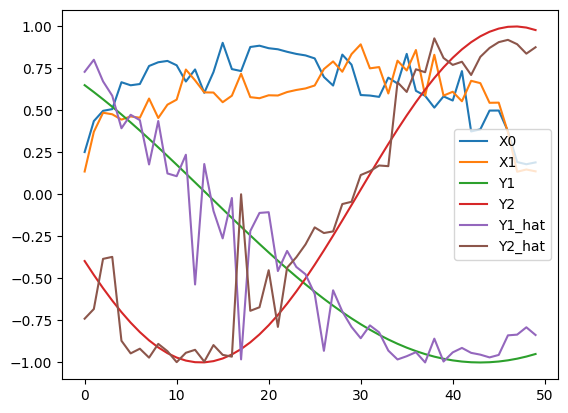

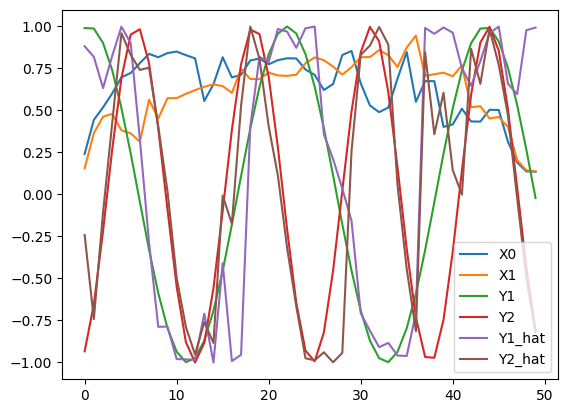

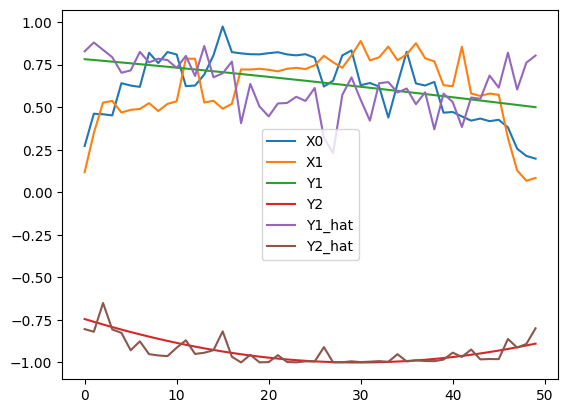

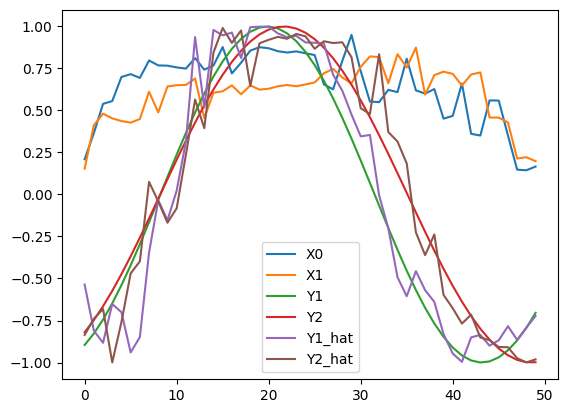

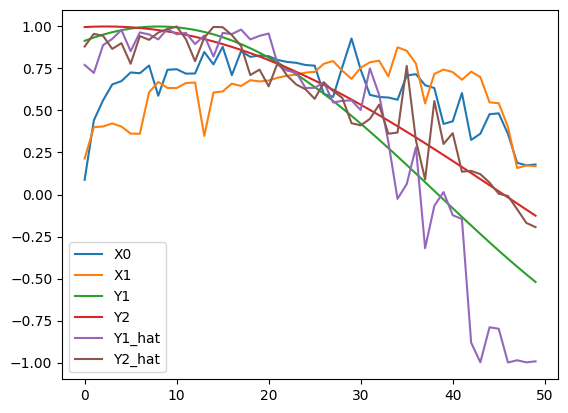

In [24]:
num_samples = 5
samples, givens = generate_samples(num_samples, y_givens)
plot_samples(num_samples, samples, givens)

# Validating the Model

In [25]:
val = torch.load("/kaggle/input/bh-data-1/validation_dataset.pt")

In [26]:
features, labels = val.tensors
features.shape, labels.shape

(torch.Size([3000, 1, 50, 2]), torch.Size([3000, 1, 50, 2]))

In [27]:
Val_Dataset = TensorDataset(features, labels)
val_loader = DataLoader(Val_Dataset, batch_size=batch_size, shuffle=True)

In [28]:
with torch.no_grad():
    
    Model.eval()
    val_x_loss = 0
    val_y_loss = 0
    val_KLD = 0
    val_loss = 0
    
    for batch in tqdm(val_loader):
        x0_x1, y1_y2 = batch
        x0_x1 = x0_x1.to(device)
        y1_y2 = y1_y2.to(device)
        
        z_mu, z_log_var, x_hat = Model(x0_x1, y1_y2)
        
        
        x_loss, KLD, y_loss, loss = loss_function(x0_x1, x_hat, z_mu, z_log_var, y1_y2)
        x_loss, KLD, y_loss, loss = x_loss.to(device), KLD.to(device), y_loss.to(device), loss.to(device)
        
        val_x_loss += x_loss.item()
        val_y_loss += y_loss.item()
        val_KLD += KLD.item()
        val_loss += loss.item()
        
val_x_loss /= len(val_loader)
val_y_loss /= len(val_loader)
val_KLD /= len(val_loader)
val_loss /= len(val_loader)
print(f'Loss: {val_loss} KLD: {val_KLD} y_loss: {val_y_loss} x_loss: {val_x_loss}')

  0%|          | 0/94 [00:00<?, ?it/s]

Loss: 0.6299278102022536 KLD: 0.00016169345125238946 y_loss: 0.16424272637417975 x_loss: 0.4655233900597755


# Creating Samples for Submission

In [29]:
score = torch.load("/kaggle/input/bh-data-original/scoring_dataset.pt")

In [30]:
x_sc, y_sc = score.tensors
x_sc.shape, y_sc.shape

(torch.Size([50, 1, 50, 2]), torch.Size([50, 1, 50, 2]))

In [31]:
Model.eval()
x0_x1 = torch.tensor([])
x0_x1 = x0_x1.to(device)
y1_y2 = torch.tensor([])
y1_y2 = y1_y2.to(device)

for i in range(50):
    x_sc_1, y_sc_1 = x_sc[i,:,:,:],y_sc[i,:,:,:]
    x_sc_1 = torch.unsqueeze(x_sc_1, dim=0)
    y_sc_1 = torch.unsqueeze(y_sc_1, dim=0)
    
    x_sc_1 = x_sc_1.to(device)
    y_sc_1 = y_sc_1.to(device)
    for j in range(30):
        z_rand = torch.randn(1, 50, 2)
        z_rand = z_rand.to(device)
        z_mu, z_log_var = Model.encoder(torch.unsqueeze(z_rand, dim=0), y_sc_1)
        z = Model.sampling(z_mu, z_log_var) 
        
        sample = Model.decoder(z, y_sc_1)
    
        x0_x1 = torch.cat([sample, x0_x1], dim=0)
        y1_y2 = torch.cat([y1_y2, y_sc_1], dim=0)

In [32]:
x0_x1 = x0_x1.to("cpu")
y1_y2 = y1_y2.to("cpu")

In [33]:
ouput = TensorDataset(x0_x1, y1_y2)

In [34]:
torch.save(ouput,"result_data_original.pt")